In [2]:
## Importing libraries

import pandas as pd
import numpy as np
import sys
import os
import re
import emoji
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [3]:
# Read the data
df = pd.read_csv('../cleaned_tweet_data.csv')
print(df.shape)
df.head()

(8674, 15)


,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Apr 22 22:17:05 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",The 10-year yield is telling us that there's a...,0.16,0.540000,en,12179,43.0,davideiacovozzi,18,55,NaN,"[{'text': 'gold', 'indices': [116, 121]}, {'te...",['axelmeyerko'],NaN
1,Fri Apr 22 13:44:53 +0000 2022,"<a href=""http://twitter.com/download/android"" ...","German 10y mortgage rate went from 0,8% to 2,5...",0.15,0.175000,en,12179,32.0,davideiacovozzi,18,55,NaN,[],['JoanaCotar'],NaN
2,Fri Apr 22 06:10:34 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",When? https://t.co/kO2FfHKaZg,0.00,0.066667,en,12179,26.0,davideiacovozzi,18,55,False,[],['MichaelAArouet'],NaN
3,Thu Apr 21 17:22:09 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",The 30-year mortgage rate in the US rises to 5...,-0.40,0.400000,en,12179,213.0,davideiacovozzi,18,55,NaN,[],['goldseek'],NaN
4,Thu Apr 21 10:32:26 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",Rates rise until something breaks … is anythin...,-0.10,0.550000,en,12179,417.0,davideiacovozzi,18,55,False,[],['charliebilello'],NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8674 entries, 0 to 8673
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          8674 non-null   object 
 1   source              8674 non-null   object 
 2   original_text       4314 non-null   object 
 3   polarity            8674 non-null   float64
 4   subjectivity        8674 non-null   float64
 5   lang                8674 non-null   object 
 6   favorite_count      8674 non-null   int64  
 7   retweet_count       4314 non-null   float64
 8   original_author     8674 non-null   object 
 9   followers_count     8674 non-null   int64  
 10  friends_count       8674 non-null   int64  
 11  possibly_sensitive  3393 non-null   object 
 12  hashtags            8674 non-null   object 
 13  user_mentions       8674 non-null   object 
 14  place               5590 non-null   object 
dtypes: float64(3), int64(3), object(9)
memory usage: 1016.6

In [5]:
# Drop unaccessary columns
# df.drop(columns=['source','original_author','friends_count','user_mentions'], axis=1, inplace=True)
df = df[['original_text','polarity']]
print(df.shape)

(8674, 2)


In [6]:
# Check missing values
df.isna().sum()

original_text    4360
polarity            0
dtype: int64

In [7]:
# Drop rows with missing value
# Remove rows with null value of tweet text
df = df[~df['original_text'].isnull()]
df.shape

(4314, 2)

## Preprocessing
The preprocessing steps are:
* Remove rows with null text value
* Change data type to string
* Lower casing 
* Remove URLs: links starting with "http" or "https" or "www" are replaced by "URL"
* Replacing emois
* Replacing usernames
* Removing non-alphabets
* Removing consecutive letters: eg convert "Heyyyy" to "Heyy"
* Removing short words: words with length less than 2
* Removing stopwords
* Lemmatizing: converting a word to its base form

In [8]:

# Change the data type of tweet text to str
df['original_text'] = df['original_text'].astype(str)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess(textdata):
    textdata = textdata.astype(str)
    processedText = []
    
    # Create Lemmatizer and Stemmer
    wordLemm = nltk.stem.WordNetLemmatizer()
    
    # Defining regex patters
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URLs with 'URL'
        tweet = re.sub(urlPattern, ' URL', tweet)
        
        # Replace all emojis
        tweet = emoji.demojize(tweet)
        
        # Replace @username to 'USER'
        tweet = re.sub(userPattern, ' USER', tweet)
        
        # Replace all non alphabets
        tweet = re.sub(alphaPattern, " ", tweet)
        
        # Replace 3 or more consecutive letters to 2 letter
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        tweetwords = ''
        for word in tweet.split():
            # Replace if the word is a stopword
            if (word not in stop_words):
                if len(word) > 1:
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
            
        
        processedText.append(tweetwords)
    
    return processedText

[nltk_data] Downloading package stopwords to /home/moges/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# cleaned_data = preprocess(df['original_text']).head()
df['original_text'] = preprocess(df['original_text'])
df.head()

,original_text,polarity
0,10 year yield telling u high risk something br...,0.16
1,german 10y mortgage rate went 50 backhand inde...,0.15
2,URL,0.00
3,30 year mortgage rate u rise 11 highest level ...,-0.40
4,rate rise something break anything broken yet ...,-0.10


In [10]:
# Categorize the texts as positive, neutral and negative based on their polarity
def text_category(p):
    if p > 0:
        return 'positive'
    elif p == 0:
        return 'neutral'
    else:
        return 'negative'
    
df['score'] = df['polarity'].map(text_category)
df = df[df['score'] != 'neutral']
df.head()
df.to_csv("cleaned_data.csv")

In [11]:
df.groupby(['score']).count()

,original_text,polarity
score,,
negative,467,467
positive,1115,1115


<AxesSubplot:ylabel='original_text'>

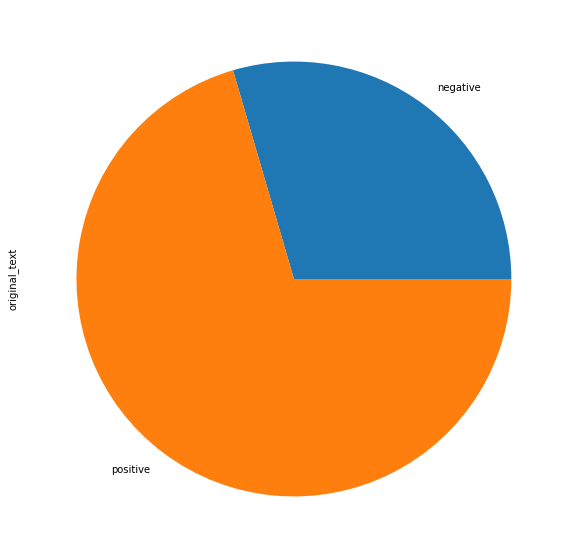

In [12]:
# visualize using PieChart
fig,axis=plt.subplots(figsize=(10,10))
df.groupby('score')['original_text'].count().plot.pie(ax=axis)

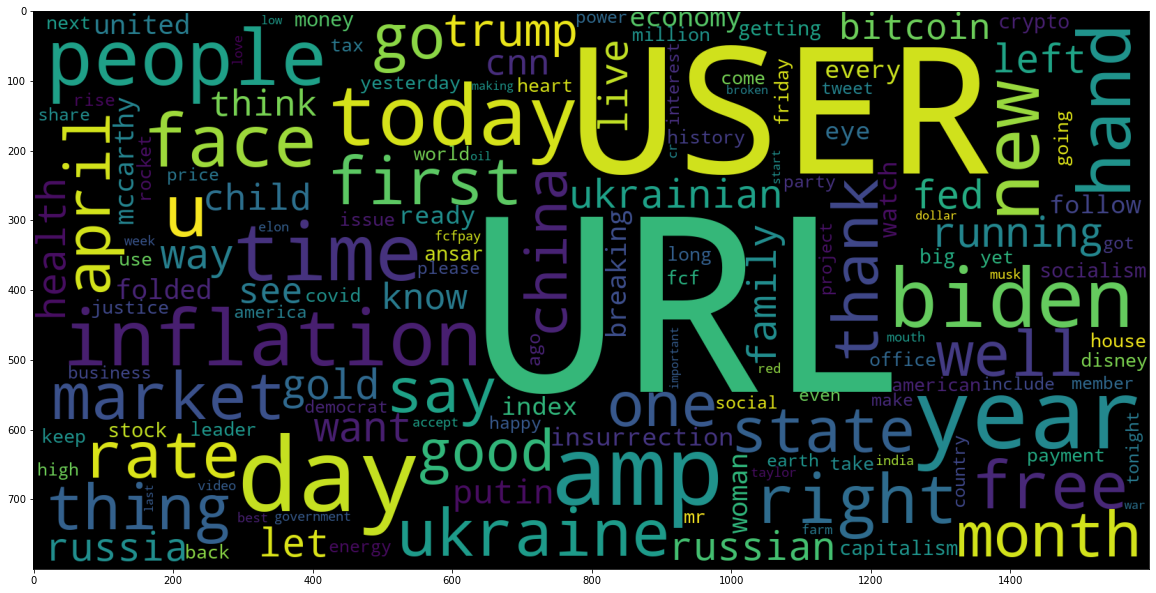

In [13]:
# Word-cloud for Negative tweets
data_neg = df[df['score'] == 'negative']['original_text']

plt.figure(figsize=(20,20))
wc = WordCloud(max_words=150, width=1600, height=800, collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

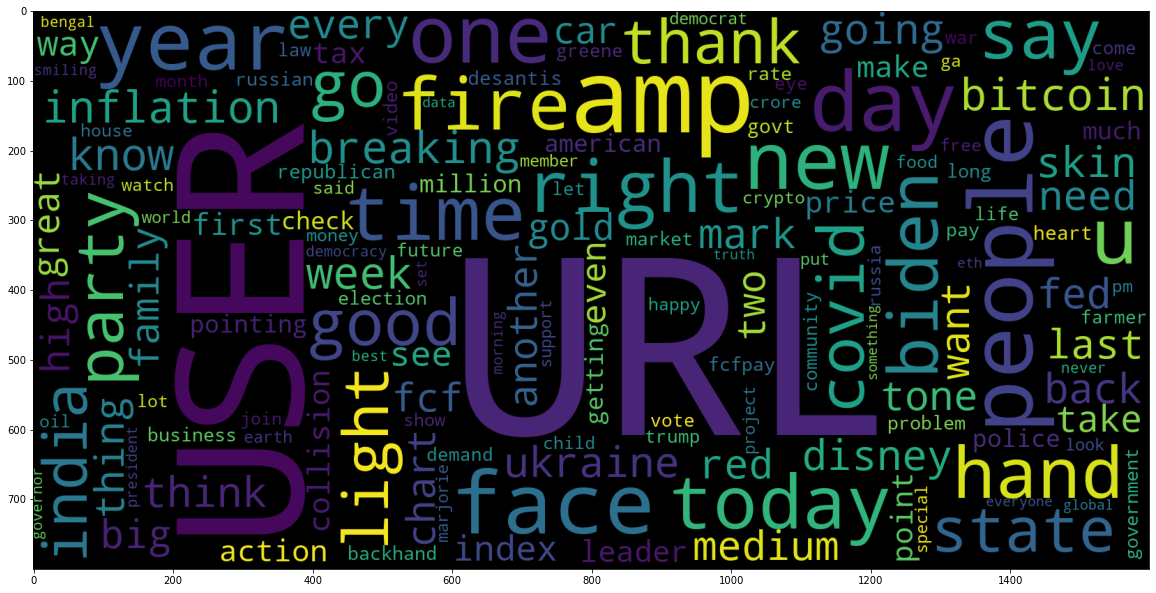

In [14]:
# Word-cloud for Positive tweets
data_pos = df[df['score'] == 'positive']['original_text']

plt.figure(figsize=(20,20))
wc = WordCloud(max_words=150, width=1600, height=800, collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

## Building Model

In [15]:
# Splitting the data
X = df['original_text']
Y = df['score']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [16]:
# TF-IDF Vectoriser

vectoriser = TfidfVectorizer(ngram_range=(3,3))
vectoriser.fit(X_train)


TfidfVectorizer(ngram_range=(3, 3))

In [17]:
# Transforming the dataset
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

In [18]:
# Building model
LRmodel = LogisticRegression(C = 2, max_iter=1000, n_jobs=-1)
LRmodel.fit(X_train, Y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

In [19]:
# Predict using the model for test dataset
Y_pred = LRmodel.predict(X_test)
test_score = LRmodel.score(X_test, Y_test)
train_score = LRmodel.score(X_train, Y_train)
print('Test score: ' , round(test_score, 2))
print('Train score: ', round(train_score, 2))

Test score:  0.72
Train score:  0.95


In [20]:
# Splitting the data
X = df['original_text']
Y = df['score']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [21]:
# TF-IDF Vectoriser

vectoriser = TfidfVectorizer(ngram_range=(3,3))
vectoriser.fit(X_train)

TfidfVectorizer(ngram_range=(3, 3))

In [22]:
# Transforming the dataset
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

In [23]:
# Building model
LRmodel = LogisticRegression(C = 2, max_iter=1000, n_jobs=-1)
LRmodel.fit(X_train, Y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

In [24]:
# Predict using the model for test dataset
Y_pred = LRmodel.predict(X_test)
test_score = LRmodel.score(X_test, Y_test)
train_score = LRmodel.score(X_train, Y_train)
print('Test score: ' , round(test_score, 2))
print('Train score: ', round(train_score, 2))

Test score:  0.72
Train score:  0.95


# Topic Modelling

In [25]:
# Import additional useful libraries for topic modelling

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import Phrases, TfidfModel, CoherenceModel
from gensim.models.phrases import Phraser

# Vis
import pyLDAvis
import pyLDAvis.gensim_models

In [26]:
df.head()

,original_text,polarity,score
0,10 year yield telling u high risk something br...,0.16,positive
1,german 10y mortgage rate went 50 backhand inde...,0.15,positive
3,30 year mortgage rate u rise 11 highest level ...,-0.40,negative
4,rate rise something break anything broken yet ...,-0.10,negative
5,buying opportunity like occur every year bond ...,0.40,positive


In [27]:
# Convert tweets to list of words
tweets_list = [tweet for tweet in df['original_text']]
word_list = [tweet.split() for tweet in tweets_list]
word_list[:2]

[['10',
  'year',
  'yield',
  'telling',
  'u',
  'high',
  'risk',
  'something',
  'breaking',
  'system',
  'gold',
  'silver',
  'URL'],
 ['german',
  '10y',
  'mortgage',
  'rate',
  'went',
  '50',
  'backhand',
  'index',
  'pointing',
  'hear',
  'sound',
  'german',
  'real',
  'estate',
  'bubble',
  'bursting',
  'URL']]

In [28]:
# ID to word dictionary
id2word = corpora.Dictionary(word_list)

corpus = []
for text in word_list:
    new = id2word.doc2bow(text)
    corpus.append(new)
    
print(corpus[0:2])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)], [(1, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)]]


In [29]:
# model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=30, random_state=100, update_every=1, passes=10, alpha="auto")

In [30]:
# Visualising the data
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/home/moges/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/home/moges/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/moges/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/moges/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/moges/anaconda3/lib/python3.9/site-packages/past/builtin

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.238438 -0.106764       1        1  5.431940
29     0.058206 -0.184817       2        1  4.826594
8     -0.277776 -0.005132       3        1  4.696974
14     0.243621 -0.217435       4        1  4.524739
25     0.251253 -0.079974       5        1  4.288314
12     0.267671  0.019465       6        1  4.220435
18     0.218568  0.085242       7        1  4.046543
21     0.057861 -0.276154       8        1  3.996840
4     -0.196626 -0.193418       9        1  3.933981
10    -0.123313 -0.219396      10        1  3.871256
15    -0.153374 -0.007385      11        1  3.806289
9     -0.242473  0.066113      12        1  3.589320
22    -0.012448 -0.054885      13        1  3.581805
0     -0.039523 -0.147905      14        1  3.441276
1      0.044237  0.258684      15        1  3.255028
2     -0.171244  0.211416      16        1  3.213713
3     -0.205964  0.147736      17        1  3.190535
24    -0.154384 -0.096765      18        1  3.072495
26    -0.038554 -0.240588      19        1  3.007220
16     0.148168 -0.184675      20        1  2.871984
13     0.160595 -0.084159      21        1  2.769529
17     0.126754  0.240166      22        1  2.729973
19    -0.103004  0.085666      23        1  2.558063
7     -0.009889  0.113102      24        1  2.246769
20    -0.086332  0.217947      25        1  2.241341
27    -0.030864  0.258975      26        1  2.229798
23     0.075694  0.064569      27        1  2.212360
6      0.140242  0.014009      28        1  2.208410
28     0.110659  0.140309      29        1  2.154015
11     0.180680  0.176053      30        1  1.782459, topic_info=          Term        Freq       Total Category  logprob  loglift
152       USER  489.000000  489.000000  Default  30.0000  30.0000
302       face   45.000000   45.000000  Default  29.0000  29.0000
396       hand   34.000000   34.000000  Default  28.0000  28.0000
21       index   18.000000   18.000000  Default  27.0000  27.0000
15    backhand   13.000000   13.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1048     biden    1.316055   37.805817  Topic30  -5.4688   0.6694
530      right    0.678658   35.350156  Topic30  -6.1310   0.0742
302       face    0.677827   45.146679  Topic30  -6.1323  -0.1716
170        way    0.675165   20.003739  Topic30  -6.1362   0.6385
46        like    0.675162   36.534460  Topic30  -6.1362   0.0361

[1962 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
518       2  0.095858     00
518       5  0.047929     00
518       6  0.047929     00
518       7  0.095858     00
518       9  0.095858     00
...     ...       ...    ...
4523     13  0.659027    yoy
4939      8  0.263132     yr
4939     15  0.526265     yr
4033      7  0.651075   yuri
3959     30  0.714946  zaria

[4618 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 30, 9, 15, 26, 13, 19, 22, 5, 11, 16, 10, 23, 1, 2, 3, 4, 25, 27, 17, 14, 18, 20, 8, 21, 28, 24, 7, 29, 12])

In [31]:
# Bigtams and triagrams
bigram_phrases = Phrases(word_list, min_count=5, threshold=50)
trigram_phrases = Phrases(bigram_phrases[word_list], threshold=50)

bigram = Phraser(bigram_phrases)
trigram = Phraser(trigram_phrases)

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams = make_bigrams(word_list)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print(data_bigrams_trigrams[0])

['10', 'year', 'yield', 'telling', 'u', 'high', 'risk', 'something', 'breaking', 'system', 'gold_silver', 'URL']


In [32]:
id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words = []
words_missing_in_tfidf = []

for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    
    for item in drops:
        words.append(id2word[item])
    
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow




In [33]:
# Visualising the data
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=30, random_state=100, update_every=1, passes=10, alpha="auto")
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/home/moges/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15    -0.292186  0.087184       1        1  6.070243
6      0.112787 -0.284286       2        1  4.752145
8      0.295602  0.043954       3        1  4.258985
4      0.046684  0.104755       4        1  3.786338
3      0.194539 -0.090974       5        1  3.766945
14    -0.018197 -0.283426       6        1  3.751866
22    -0.208819  0.198421       7        1  3.544451
23     0.229313  0.073468       8        1  3.536056
27    -0.213597 -0.091611       9        1  3.531709
1     -0.302088 -0.050629      10        1  3.470344
20    -0.141227  0.191610      11        1  3.340507
11    -0.086732 -0.246044      12        1  3.328512
26    -0.205210 -0.160430      13        1  3.309355
9      0.171559  0.002762      14        1  3.298114
24     0.042281  0.252006      15        1  3.294751
10     0.262380 -0.101776      16        1  3.145540
25     0.078982 -0.131947      17        1  3.133984
16    -0.167905  0.080293      18        1  3.091020
13    -0.053344 -0.087873      19        1  3.054823
5      0.144823  0.175089      20        1  3.008179
2      0.117196  0.252329      21        1  2.975817
18    -0.016826  0.223838      22        1  2.970897
28    -0.087325  0.246542      23        1  2.953922
21     0.189065 -0.190757      24        1  2.905168
17     0.217581  0.163309      25        1  2.892731
0     -0.146113 -0.204504      26        1  2.751409
29     0.048349 -0.201750      27        1  2.573128
7     -0.176361 -0.009944      28        1  2.505132
12     0.034618 -0.014891      29        1  2.500590
19    -0.069827  0.055283      30        1  2.497340, topic_info=           Term        Freq       Total Category  logprob  loglift
150        USER  467.000000  467.000000  Default  30.0000  30.0000
186         amp   73.000000   73.000000  Default  29.0000  29.0000
370         day   47.000000   47.000000  Default  28.0000  28.0000
324   inflation   29.000000   29.000000  Default  27.0000  27.0000
1199      biden   25.000000   25.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
83        going    1.399219   20.458156  Topic30  -5.6296   1.0075
558       thank    1.399218   16.469096  Topic30  -5.6296   1.2244
456        need    1.399216   17.837190  Topic30  -5.6296   1.1446
360       state    1.399216   24.655089  Topic30  -5.6296   0.8209
44         like    1.399212   36.153707  Topic30  -5.6296   0.4381

[1929 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
509       1  0.050421         00
509       2  0.100842         00
509       4  0.050421         00
509       6  0.050421         00
509       8  0.050421         00
...     ...       ...        ...
4969      3  0.266394         yr
4969      7  0.532788         yr
858      16  0.681263  zakharova
3442     29  0.705087         ze
993       9  0.678037         zz

[4854 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 7, 9, 5, 4, 15, 23, 24, 28, 2, 21, 12, 27, 10, 25, 11, 26, 17, 14, 6, 3, 19, 29, 22, 18, 1, 30, 8, 13, 20])